1. ## Credit Card Fraud Detection

In [1]:
# Load libraries for analysis and visualization
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
%matplotlib inline
# import plotly.offline as py     # Open source library for composing, editing, and sharing interactive data visualization 
from matplotlib import pyplot
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls

from collections import Counter

# Machine learning libraries
# import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics

import sklearn         # Collection of machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv("../input/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
import os
os.cpu_count()

32

### 1. EDA : Exploration Data Analysis + Feature engineering

### 1-1 Correalation
    - PCA를 한 결과이기 때문에 전체를 보내는 것은 의미 없다
    - 시간과 amount, Class 만 봐보자

- amount와 Class 간의 그래프
    - amount가 낮을 수록 Fraud 일 확률이 높다
    - amount가 심하게 skew 되어 있다. -> 로그를 씌워주자

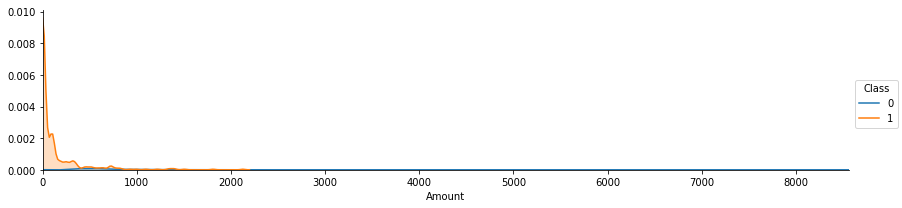

In [4]:
## amount + Class
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( df, hue = 'Class', aspect=4 ) # 여러개의 그림을 그리기
a.map(sns.kdeplot, 'Amount', shade= True ) # 해당하는 모든 그림에 kdeplot 넣기 # 점을 이어준다!
a.set(xlim=(0 , df['Amount'].max()/3))
a.add_legend()

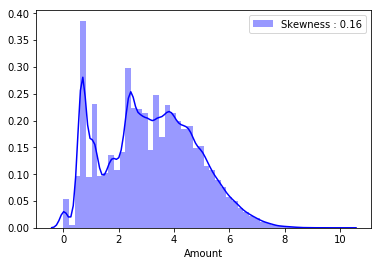

In [5]:
# log(1+Amount) 분포
g= sns.distplot(np.log1p(df["Amount"]), color = 'b', label = "Skewness : %.2f" % np.log1p(df["Amount"]).skew())
g= g.legend(loc= "best")


df['Amount'] = np.log1p(df["Amount"])

- log(1+amount)와 Fraud 발생율 비교
    - Amount가 0.5 미만일때는 Fraud가 발생할 확률이 압도적으로 높다.
    - 1.7 이상일 때는 Class 가 0일 확률이 더 높다.
    - 이러한 Feature를 추가해주자

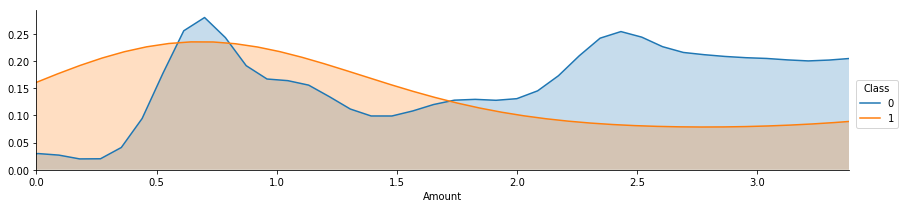

In [6]:
## amount + Class
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( df, hue = 'Class', aspect=4 ) # 여러개의 그림을 그리기
a.map(sns.kdeplot, 'Amount', shade= True ) # 해당하는 모든 그림에 kdeplot 넣기 # 점을 이어준다!
a.set(xlim=(0 , df['Amount'].max()/3))
a.add_legend()

In [7]:
# Feature 추가

def changing(x):
    if x < 0.5 : result = 'A'
    elif x < 1.7 : result = 'B'
    else :result = 'C'
    return result
    
df['Amount_class']= df['Amount'].map(changing)

#### time과 Class 간의 관계
    - 특정 Time에는 Fraud(Class= 1)이 발생할 확률이 더 높다.
    - 정상 Transaction은 발생하는 주기가 있지만, Fraud는 꾸준하다
      즉 특정 시간대에는 Fraud가 일어날 확률이 더 높다고 예측하면 된다.
    - Feature를 추가하자

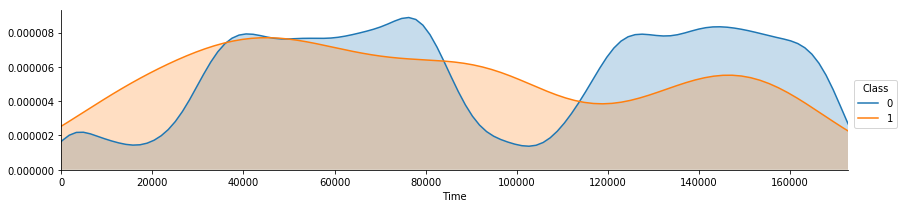

In [8]:
## amount + Class
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( df, hue = 'Class', aspect=4 ) # 여러개의 그림을 그리기
a.map(sns.kdeplot, 'Time', shade= True ) # 해당하는 모든 그림에 kdeplot 넣기 # 점을 이어준다!
a.set(xlim=(0 , df['Time'].max()))
a.add_legend()

In [9]:
# Time Class 변경 : Feature 추가
def temp(x):
    if x<40000 : result = 'A'
    elif   x<82000 : result = 'B'
    elif  x<120000 : result = 'C'
    else : result = 'D'
    return result

df['Time'] = df['Time'].map(temp)

### 2 class 비율 확인하기
    - class 가 1인 것이 너무 적다 !
    - Oversampling, undersampling
        - oversampling은 거짓말이 될 수 있고
          undersampling은 부분만 볼수가 있다. 
    - classfier에서 가중치를 주는 방법이 있다.
    

In [ ]:
plt.hist(df['Class'],bins = 10)

### 3. Feature importance 
    - 어떤 변수가 중요한 것인가
    - random forest로 뽑아보자
    - V14, V10, V17,  V12, V3 가 가장 영향력이 있는 것으로 나온다.

In [10]:
fi_df = pd.get_dummies(df)

In [11]:
RF = RandomForestClassifier(n_estimators = 100, class_weight = {0:0.5,1:100},n_jobs=10)
RF.fit(fi_df.drop('Class',axis= 1),fi_df['Class'])


RandomForestClassifier(bootstrap=True, class_weight={0: 0.5, 1: 100},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=10, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [12]:
Importance = pd.DataFrame({'FI' :RF.feature_importances_},
                                index = fi_df.drop('Class',axis= 1).columns)\
                     .sort_values("FI",ascending= False)
Importance.head()

,FI
V14,0.154245
V12,0.151010
V10,0.125062
V11,0.096757
V17,0.096283


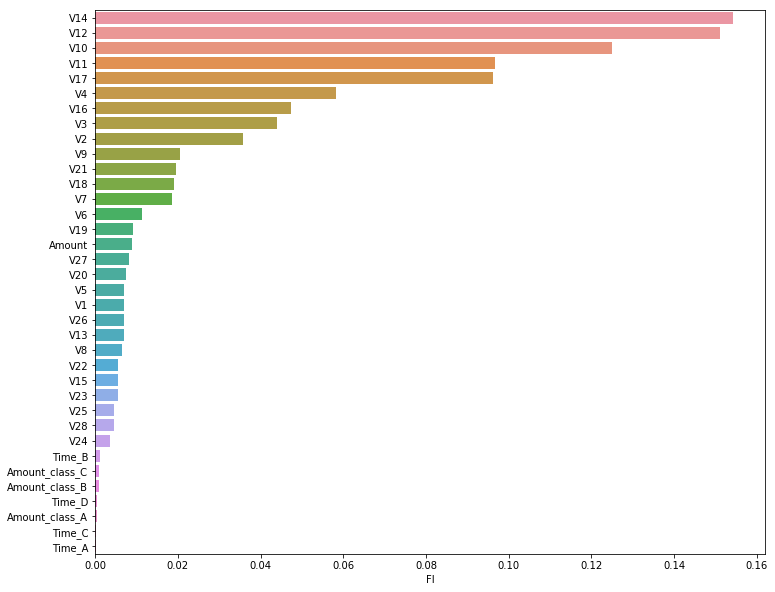

In [13]:
fig, axes=  plt.subplots(figsize = (12,10))
g = sns.barplot(y=Importance.index, x= Importance.FI)

### 4. Test train split

In [14]:
from sklearn.model_selection import train_test_split
df_dummies = pd.get_dummies(df,drop_first = True)
train, test = train_test_split(df_dummies, test_size = 0.2, random_state = 42)
x_train, y_train = train.drop('Class', axis = 1), train.loc[:,['Class']]
x_test, y_test = test.drop('Class', axis = 1), test.loc[:,['Class']]
# y_train
# print(train.Class.value_counts())
# print(test.Class.value_counts())

### 4. Sampling - Oversampling
    - pipeline을 만드는 방법과 단순 하나 fitting 하는 방법이 있는데
    - pipeline은 테이블 하나는 가능하지만 두개는 잘 안된다.
    - Over sampling을 실시한다

In [15]:
# def resampling(x_train, y_train):
#     number_fraud = len(y_train[y_train['Class']==1])
#     fraud_index = y_train[y_train['Class']==1].index
#     normal_index =  y_train[y_train['Class']==0].index

#     # random choice , 5배를 가져오자
#     random_index =  np.random.choice(normal_index,number_fraud*5,replace = False)
#     index = np.concatenate([fraud_index,random_index])

#     inputs = x_train.loc[index,:]
#     output = y_train.loc[index,:]
#     return inputs, output

from imblearn.over_sampling import SMOTE 
def resampling(x_train, y_train):
    sm = SMOTE(random_state=42)
    inputs, outputs = sm.fit_sample(x_train, y_train)
    return inputs, outputs
inputs, outputs = resampling(x_train,y_train)
inputs = pd.DataFrame(inputs, columns = x_train.columns)
outputs =  pd.DataFrame(outputs, columns = y_train.columns)



In [ ]:
# outputs.Class.value_counts()

### 5.  Simple Modeling - undersampling
    - undersampling 한 데이터로 Fitting 하는 모델이 더 성능이 좋다(Whole data 대비)

- Logistic Regression

In [16]:
from sklearn import metrics
logit= LogisticRegression( penalty = 'l1',n_jobs=20)
logit.fit(inputs,outputs)
y_predict = logit.predict_proba(x_test)

# logit.predict_proba
# auc 값
# print(y_predict[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), y_predict[:,1])
auc = metrics.auc(fpr, tpr)
prediction= logit.predict(x_test)
recall = metrics.recall_score( y_test.values.ravel(),prediction)
print("auc ", auc, "recall", recall)

auc  0.9799446297933918 recall 0.9183673469387755


- SVM

In [ ]:
# svc = SVC()
# svc.fit(inputs,outputs)
# pred = svc.predict(x_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred)
# metrics.auc(fpr, tpr)

- K-Nearest Neighbors (KNN)

In [ ]:
# knn = KNeighborsClassifier(n_neighbors = 3,n_jobs=20)
# knn.fit(inputs,outputs)
# pred = knn.predict(x_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred)
# metrics.auc(fpr, tpr)

- Naive Bayes Classfier

In [ ]:
# gaussian = GaussianNB()
# gaussian.fit(inputs,outputs)
# Y_pred = gaussian.predict(x_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred)
# metrics.auc(fpr, tpr)

- Decision Tree

In [ ]:
# decision_tree = DecisionTreeClassifier()
# decision_tree.fit(inputs,outputs)
# pred = decision_tree.predict(x_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred)
# metrics.auc(fpr, tpr)

- Randomforest

In [17]:
random_forest = RandomForestClassifier(n_estimators=100, n_jobs = 20)
random_forest.fit(inputs,outputs)
pred = random_forest.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred[:,1])
auc = metrics.auc(fpr, tpr)
prediction= logit.predict(x_test)
recall = metrics.recall_score( y_test.values.ravel(),prediction)
print("auc ", auc, "recall", recall)

auc  0.9814392449438976 recall 0.9183673469387755


- gradientboosting

In [ ]:
# GBoost = GradientBoostingClassifier( )
# GBoost.fit(inputs,outputs)
# pred =GBoost.predict(x_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred)
# metrics.auc(fpr, tpr)

- LightGBM


In [ ]:
# params = {
#         'learning_rate': 0.10,
#         'is_unbalance': 'true', # replaced with scale_pos_weight argument
#     }
# x_train2, x_val, y_train2, y_val = train_test_split(inputs,outputs, test_size = 0.2)
# # y_val
# train_df = lgb.Dataset(x_train2,y_train2.values.ravel())
# val_df = lgb.Dataset(x_val, y_val.values.ravel(), reference=train_df)
# lgbtrain = lgb.train(params, train_df, num_boost_round = 10, valid_sets=[val_df])
# pred_prob= lgbtrain.predict(x_test)
# # predictiong 값 바꾸기
# func = np.vectorize((lambda x : 1 if x>0.5 else 0))
# pred = func(pred_prob)

# # Auc
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred)
# metrics.auc(fpr, tpr)

### 6. Simple Modeling : Whole Data

- logistic regression (Whole Data)

In [ ]:
# logit2= LogisticRegression( penalty = 'l1')
# logit2.fit(x_train,y_train)
# y_predict = logit2.predict(x_test)
# # auc 값
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), y_predict)
# metrics.auc(fpr, tpr)

- Naive Bayes Classfier (Whole data)

In [ ]:
# gaussian2 = GaussianNB()
# gaussian2.fit(x_train,y_train)
# Y_pred = gaussian2.predict(x_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred)
# metrics.auc(fpr, tpr)

- Random forest (whole data)

In [ ]:
# random_forest = RandomForestClassifier(n_estimators=100)
# random_forest.fit(x_train,y_train)
# pred = random_forest.predict(x_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred)
# metrics.auc(fpr, tpr)

- Light GBM 

In [ ]:
# params = {
#         'learning_rate': 0.10,
#         'is_unbalance': 'true', # replaced with scale_pos_weight argument
#  }
# x_train2, x_val, y_train2, y_val = train_test_split(x_train,y_train, test_size = 0.2)
# # y_val
# train_df = lgb.Dataset(x_train2,y_train2.values.ravel())
# val_df = lgb.Dataset(x_val, y_val.values.ravel(), reference=train_df)
# lgbtrain = lgb.train(params, train_df, num_boost_round = 10, valid_sets=[val_df])
# pred_prob= lgbtrain.predict(x_test)
# # predictiong 값 바꾸기
# func = np.vectorize((lambda x : 1 if x>0.5 else 0))
# pred = func(pred_prob)

# # Auc
# fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), pred)
# metrics.auc(fpr, tpr)
# for name in vars().keys():
#     print(name)

### 7. Modeling : Cross Validation
    - Logistic Regression, Naive Bayese Classfier, Randomforest, Gradientboosting ,SVM
    - 결과
        - Logistic Regression, Random forest, Gradient boosting 의 수렴지점이 가장 높다
        - 특히 Gradient boosting이 데이터가 많아지면 더 높은 지점에서 수렴한다.
        

In [ ]:

from sklearn.model_selection import KFold
kfold = KFold(n_splits = 7,shuffle=True) # 10개씩 나눠서 10번 수행

classes = ['Logistic Regression', 'RandomForest','Gradientboosting']
classifier= [LogisticRegression( penalty = 'l1'),
             RandomForestClassifier(n_estimators=100),GradientBoostingClassifier( )]
%env JOBLIB_TEMP_FOLDER=/tmp
cv_results = []

# for i, model in enumerate(classifier) :
#     cv_results.append(cross_val_score(model,inputs,outputs, scoring = 'roc_auc',cv = kfold,n_jobs=-1 ))
#     print('auc : ', classes[i], round(cv_results[i].mean(),2))
for i, model in enumerate(classifier) :
    cv_results.append(cross_val_score(modeggl,inputs,outputs, scoring = 'recall',cv = kfold,n_jobs=-1 ))
    print('recall : ', classes[i], round(cv_results[i].mean(),2))


  

env: JOBLIB_TEMP_FOLDER=/tmp
recall :  Logistic Regression 0.93
recall :  RandomForest 1.0
recall :  Gradientboosting 0.98


In [ ]:
# #@title 기본 제목 텍스트
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
#     """Generate a simple plot of the test and training learning curve"""
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
#         scoring = 'roc_auc', shuffle =True)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")
#     plt.legend(loc="best")
#     return plt

# for i in range(len(classes)):
# #     print(inputs)
#     g = plot_learning_curve(classifier[i],classes[i],inputs,outputs,cv=kfold)


### 8. Parameter search
    - Logistic Regression, Random forest, Gradient boosting 
    - Logistic은 안할것
    - Random forest는 0.980, gradient boosting은 0.983 이다

- Random Forest
    - default 값으로 prediction 했을때 auc가 0.937이었는데
      best로 찾은것이 0.932 이다. 
    - grid search할때 default 값을 빼서 그런것인데 결국 default가 제일 좋았던것

In [ ]:
rf_param_grid = {"max_depth": [None],
              "max_features": ['sqrt'],
              "min_samples_split": [2, 10],
              "min_samples_leaf": [1, 10],
              "bootstrap": [True],
              "n_estimators" :[300,600],
              "criterion": ["gini"]}

gsrandom_forest = GridSearchCV(random_forest,param_grid = rf_param_grid,n_jobs=20,
                               cv=kfold, scoring="recall", verbose = 1)
gsrandom_forest.fit(inputs,outputs)
random_forest_best = gsrandom_forest.best_estimator_
gsrandom_forest.best_score_

In [ ]:
# Random forest 로 test error
y_predict= random_forest_best.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), y_predict[:,1])
auc = metrics.auc(fpr, tpr)

prediction= random_forest_best.predict(x_test)
recall = metrics.recall_score( y_test.values.ravel(),prediction)
print("auc ", auc, "recall", recall)

- Gradient boosting
    - default parameter로 fit하여 prediction 했을때 auc 0.940 이였고
      grid search 해서 찾아낸 parameter로 했을 때 0.946 이다
    - 모든 모델을 통틀어서 0.946이 가장 높은 auc를 기록했다.

In [ ]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100]#,200,300],
              'learning_rate': [0.1,0.01], #[0.1, 0.05, 0.01],
              'max_depth': [1,4],
              'min_samples_leaf': [100,150],
              'max_features': ["sqrt"]}
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid,n_jobs=-1,
                     cv=kfold, scoring="roc_auc", verbose = 1)
gsGBC.fit(inputs,outputs)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

In [ ]:
# Gradient boosting 으로 test error 체크
y_predict= GBC_best.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), y_predict[:,1])
auc = metrics.auc(fpr, tpr)

prediction= GBC_best.predict(x_test)
recall = metrics.recall_score( y_test.values.ravel(),prediction)
print("auc ", auc, "recall", recall)

### 9. Ensemble (combine) models
    - Random forest 와 Gradient Boosting best 결과를 합쳐보자
    - 두 결과를 합쳐서 Voting을 해보니 오히려 둘의 auc값보다 떨어졌다.

In [ ]:
Voting = VotingClassifier(estimators =[('Randomforest', random_forest_best),
                                     ('Gradientboosting', GBC_best)], voting ='hard',n_jobs=20)
Voting.fit(inputs,outputs)
y_predict = Voting.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), y_predict)
metrics.auc(fpr, tpr)

- logistic regression도 합쳐보자 
    - 결과는 조금 더 올라갔다

In [ ]:
Voting = VotingClassifier(estimators =[('Randomforest', random_forest_best),
                                     ('Gradientboosting', GBC_best),
                                      ('logit',logit)
                                      ], voting ='soft',n_jobs =20)
Voting.fit(inputs,outputs)
y_predict = Voting.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), y_predict[:,1])
auc = metrics.auc(fpr, tpr)

prediction= Voting.predict(x_test)
recall = metrics.recall_score( y_test.values.ravel(),prediction)
print("auc ", auc, "recall", recall)


- Naive Bayese Classfier 합쳐보자
    - 떨어졌다

In [ ]:

Voting = VotingClassifier(estimators =[('Randomforest', random_forest_best),
                                     ('Gradientboosting', GBC_best),
                                      ('logit',logit),
                                       ('Naive',gaussian)
                                      ], voting ='hard',n_jobs =20)
Voting.fit(inputs,outputs)
y_predict = Voting.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), y_predict)
metrics.auc(fpr, tpr)

### 10. Best model의 confusion matrix
    - threshold를 어디에서 끊는것이 좋은지를 결정해야한다
    - roc curve를 먼저 그리자
    - 어디에서 끊어야할까? 

In [ ]:
y_predict= GBC_best.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values.ravel(), y_predict)
roc_auc = metrics.auc(fpr, tpr)
# roc curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- threshold 0.5일때의 confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- recall은 높은데 , precision이 너무 낮다.
- precision 1이라고 예측했는데 0인 경우
- recall : 실제 1인데 1이라고 예측하는 비율
    - 1을 과하게 예측 하고 있다.

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix


cnf_matrix = confusion_matrix(y_test.values.ravel(), y_predict)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix')


## Best model

In [ ]:
GBC_best

## 11 . Stacking 
